### Import Packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load pickle file 

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')

Partition data into unary, binary, ternary and quarternary compounds

In [3]:
data['k-nary'] = data['composition'].apply(lambda x: len(x))

Fill in NaN values and shuffle data

In [4]:
data.fillna(value=0.0, inplace=True)
data = shuffle(data)

Input X and y

In [5]:
x = data.drop(['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
               'K_VRH', 'poisson_ratio', 'structure', 'composition', 
               'k-nary'], 1)

y_K = np.log(data['K_VRH'])
y_G = np.log(data['G_VRH'])

Save k-nary data for later use

In [6]:
k_nary = data['k-nary']
k_nary_test = k_nary[int(data.shape[0]*0.8):]

Separate data into training and testing data
(80% training and 20% testing)

In [7]:
x_train, x_test = x[:int(data.shape[0]*0.8)], x[int(data.shape[0]*0.8):]
y_K_train, y_K_test = y_K[:int(data.shape[0]*0.8)], y_K[int(data.shape[0]*0.8):]
y_G_train, y_G_test = y_G[:int(data.shape[0]*0.8)], y_G[int(data.shape[0]*0.8):]

Train data using best algorithm in `DeJong_02_prediction.ipynb`.

##### K (bulk modulus) 

In [8]:
%%time
gradient_K = GradientBoostingRegressor(n_estimators=500, max_depth=3)
gradient_K.fit(x_train, y_K_train)

CPU times: user 3.06 s, sys: 11.9 ms, total: 3.07 s
Wall time: 3.09 s


In [9]:
y_K_pred = gradient_K.predict(x_test)

Calculate the errors of prediction

In [10]:
mae_K = mean_absolute_error(y_K_test, y_K_pred)
rmse_K = np.sqrt(mean_squared_error(y_K_test, y_K_pred))
r2_K = r2_score(y_K_test, y_K_pred)

##### G (shear modulus) 

In [11]:
%%time
gradient_G = GradientBoostingRegressor(n_estimators=500, max_depth=3)
gradient_G.fit(x_train, y_G_train)

CPU times: user 3.17 s, sys: 16 ms, total: 3.19 s
Wall time: 3.21 s


In [12]:
y_G_pred = gradient_G.predict(x_test)

Calculate the errors of prediction

In [13]:
mae_G = mean_absolute_error(y_G_test, y_G_pred)
rmse_G = np.sqrt(mean_squared_error(y_G_test, y_G_pred))
r2_G = r2_score(y_G_test, y_G_pred)

Plot the predictions

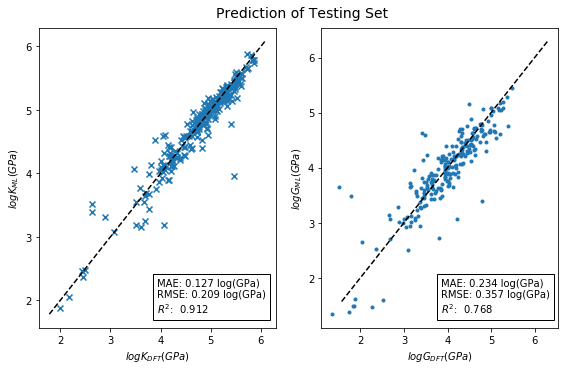

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Prediction of Testing Set", fontsize=14, x=0.53, y=1.02)

ax1.set_xlabel("$log K_{DFT} (GPa)$")
ax1.set_ylabel("$log K_{ML} (GPa)$")

ax1.scatter(y_K_test, y_K_pred, marker='x')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.5, 0.05, 
         'MAE: {:.3f} log(GPa)\nRMSE: {:.3f} log(GPa)\n$R^2$:  {:.3f}'.format(mae_K, rmse_K, r2_K),
         transform=ax1.transAxes,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})


ax2.set_xlabel("$log G_{DFT} (GPa)$")
ax2.set_ylabel("$log G_{ML} (GPa)$")

ax2.scatter(y_G_test, y_G_pred, marker='.')
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax2.text(1.7, 0.05, 
         'MAE: {:.3f} log(GPa)\nRMSE: {:.3f} log(GPa)\n$R^2$:  {:.3f}'.format(mae_G, rmse_G, r2_G),
         transform=ax1.transAxes,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches(8, 5)
fig.tight_layout()

*Finding*: As compared to the paper, our error is orders of magnitude larger. Fit and prediction for G is worse than K.  

#### Plot different k-nary 

So here I'm initializing a dictionary to partition compounds into their respective k-nary groups.

In [15]:
K_test = {1:[], 2:[], 3:[], 4:[]}
K_pred = {1:[], 2:[], 3:[], 4:[]}

G_test = {1:[], 2:[], 3:[], 4:[]}
G_pred = {1:[], 2:[], 3:[], 4:[]}

In [16]:
k_nary_test = k_nary_test.reset_index(drop=True)
y_K_test = y_K_test.reset_index(drop=True)
y_G_test = y_G_test.reset_index(drop=True)

Partitioning the compounds

In [17]:
for i in range(k_nary_test.shape[0]):
    K_test[k_nary_test[i]].append(y_K_test[i])
    K_pred[k_nary_test[i]].append(y_K_pred[i])
    
    G_test[k_nary_test[i]].append(y_G_test[i])
    G_pred[k_nary_test[i]].append(y_G_pred[i])

Plot the predictions (Our dataset consists of 19 unary, 169 binary, 49 ternary and 0 quarternary compounds)

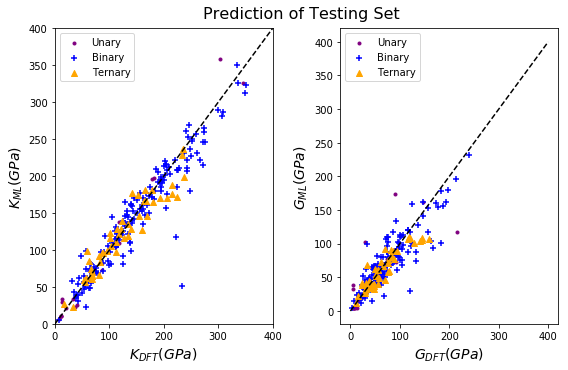

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Prediction of Testing Set", fontsize=16, x=0.53, y=1.02)

ax1.set_xlabel("$K_{DFT} (GPa)$", fontsize=14)
ax1.set_ylabel("$K_{ML} (GPa)$", fontsize=14)
ax1.set_xlim(right=400)
ax1.set_ylim(top=400)

ax1.scatter(np.exp(K_test[1]), np.exp(K_pred[1]), color='purple', marker='.', label='Unary')
ax1.scatter(np.exp(K_test[2]), np.exp(K_pred[2]), color='blue', marker='+', label='Binary')
ax1.scatter(np.exp(K_test[3]), np.exp(K_pred[3]), color='orange', marker='^', label='Ternary')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.legend()

ax2.set_xlabel("$G_{DFT} (GPa)$", fontsize=14)
ax2.set_ylabel("$G_{ML} (GPa)$", fontsize=14)

ax2.scatter(np.exp(G_test[1]), np.exp(G_pred[1]), color='purple', marker='.', label='Unary')
ax2.scatter(np.exp(G_test[2]), np.exp(G_pred[2]), color='blue', marker='+', label='Binary')
ax2.scatter(np.exp(G_test[3]), np.exp(G_pred[3]), color='orange', marker='^', label='Ternary')
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax2.legend()

fig.set_size_inches(8, 5)
fig.tight_layout()

*Finding*: We don't have quarternary compounds. Prediction of ternary compound is generally better.